In [1]:
import pickle as pkl
import sys
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
tr_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/validation.csv")

In [4]:
def ortb1_bidding(df, c=20, lambda_=0.00000052):
    df["pred_bidprice"] = df["pctr"].apply(lambda x: np.sqrt((c/lambda_ * x) + c**2) - c)
    return df

def ortb2_bidding(df, c=20, lambda_=0.00000052):
    df["pred_bidprice"] = df["pctr"].apply(
        lambda x: c*(((x + np.sqrt(c**2 * lambda_**2 + x**2)) \
                      /(c*lambda_))**(1/3) - \
                     ((c*lambda_) \
                      / (x + np.sqrt(c**2 * lambda_**2 + x**2))**(1/3))))
    return df

### Loading pCTRs

In [5]:
tr_pctr_df = pd.read_csv("pctr_model/train_pctr.csv")
val_pctr_df = pd.read_csv("pctr_model/validation_pctr.csv")
with open("pctr_model/info.pkl", "rb") as f:
    infos = pkl.load(f)

In [6]:
tr_df = tr_df[["click", "payprice"]]
tr_df["pctr"] = tr_pctr_df["pctr"]
tr_df["avgctr"] = infos["avg_ctr"]
val_df = val_df[["click", "payprice"]]
val_df["pctr"] = val_pctr_df["pctr"]
val_df["avgctr"] = infos["avg_ctr"]

### Testing ORTB1 using paper's parameters

In [7]:
def estimate(df, budget=6250000):
    spend = 0
    clicks = 0
    impressions = 0
    for click, payprice, bidprice in df[["click", "payprice", "pred_bidprice"]].values:
        if spend + payprice > budget:
            break
        # A bid will be failed if bidprice is lower than payprice
        if bidprice > payprice:
            spend += payprice
            clicks += click
            impressions += 1.0
    ctr = (clicks / impressions)
    cpm = (spend / impressions) * 1000
    cpc = (spend / clicks) if clicks > 0 else 0
    return {
        "impressions": impressions,
        "ctr": ctr,
        "clicks": clicks,
        "spend": spend,
        "cpm": cpm,
        "cpc": cpc
    }

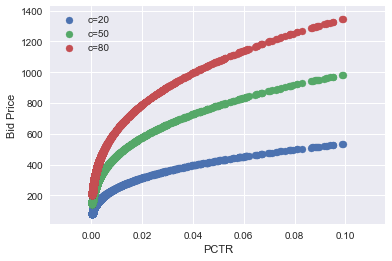

In [44]:
val_tdf1 = ortb2_bidding(val_df.copy())
tdf = val_tdf1[val_tdf1["pctr"] < 0.1]
plt.scatter(tdf["pctr"], tdf["pred_bidprice"], label="c=20")
plt.xlabel("PCTR")
plt.ylabel("Bid Price")
val_tdf2 = ortb2_bidding(val_df.copy(), c=50)
tdf = val_tdf2[val_tdf2["pctr"] < 0.1]
plt.scatter(tdf["pctr"], tdf["pred_bidprice"], label="c=50")
val_tdf3 = ortb2_bidding(val_df.copy(), c=80)
tdf = val_tdf3[val_tdf3["pctr"] < 0.1]
plt.scatter(tdf["pctr"], tdf["pred_bidprice"], label="c=80")
plt.legend()

### Tuning ORTB1

In [ ]:
lambda_=5.2e-7 -> c=48 -> lambda_ = 2.3e-06 -> c=45

99/100 done

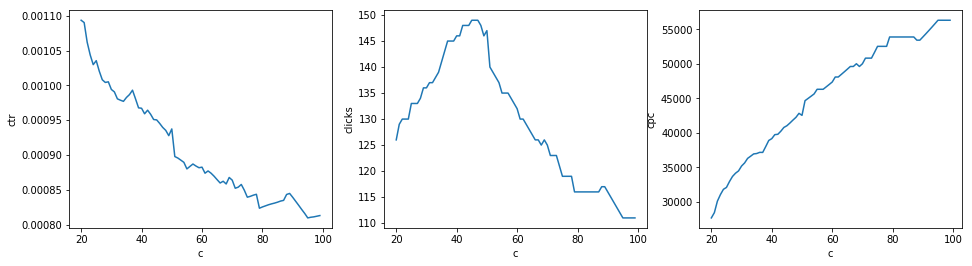

In [8]:
# Fix lambda_=0.00000052, Tuning c
res_dict_list = []
for c in range(20, 100, 1):
    tdf = ortb1_bidding(val_df.copy(), c=c, lambda_=2.3e-06)
    res = estimate(tdf)
    res["c"] = c
    res_dict_list.append(res)
    sys.stdout.write("\r{}/{} done".format(c ,100))
    sys.stdout.flush()
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
x = [item["c"] for item in res_dict_list]
y = [item["ctr"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("ctr")
plt.plot(x, y)
ax1 = fig.add_subplot(132)
x = [item["c"] for item in res_dict_list]
y = [item["clicks"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("clicks")
plt.plot(x, y)
ax1 = fig.add_subplot(133)
x = [item["c"] for item in res_dict_list]
y = [item["cpc"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("cpc")
plt.plot(x, y)

In [9]:
res_dict_list[np.argmax([item["clicks"] for item in res_dict_list])]

{'c': 45,
 'clicks': 149.0,
 'cpc': 41010.80536912752,
 'cpm': 38972.466883087887,
 'ctr': 0.00095029752603751445,
 'impressions': 156793.0,
 'spend': 6110610.0}

99/100 done

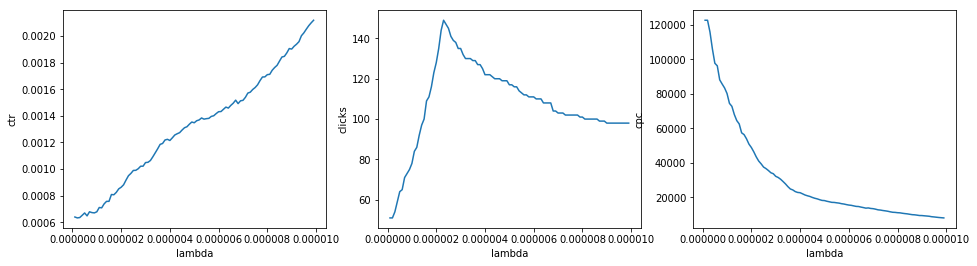

In [10]:
# Fix c=48, Tuning lambda_
res_dict_list = []
for lam_ in range(1, 100, 1):
    lam = lam_ * 0.0000001
    tdf = ortb1_bidding(val_df.copy(), c=45, lambda_=lam)
    res = estimate(tdf)
    res["lambda"] = lam
    res_dict_list.append(res)
    sys.stdout.write("\r{}/{} done".format(lam_ ,100))
    sys.stdout.flush()
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
x = [item["lambda"] for item in res_dict_list]
y = [item["ctr"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("ctr")
plt.plot(x, y)
ax1 = fig.add_subplot(132)
x = [item["lambda"] for item in res_dict_list]
y = [item["clicks"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("clicks")
plt.plot(x, y)
ax1 = fig.add_subplot(133)
x = [item["lambda"] for item in res_dict_list]
y = [item["cpc"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("cpc")
plt.plot(x, y)

In [11]:
idx = np.argmax([item["clicks"] for item in res_dict_list])
res_dict_list[idx]

{'clicks': 149.0,
 'cpc': 41010.80536912752,
 'cpm': 38972.466883087887,
 'ctr': 0.00095029752603751445,
 'impressions': 156793.0,
 'lambda': 2.3e-06,
 'spend': 6110610.0}

* best ORTB1 parameter: c=45, lambda=2.3e-06

### Tuning ORTB2

99/100 done

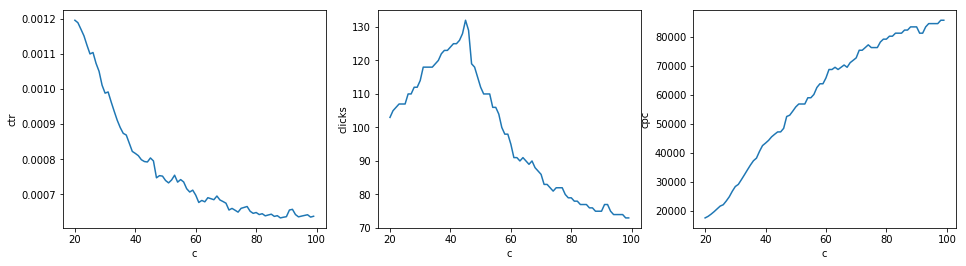

In [17]:
# Fix lambda_=0.00000052, Tuning c
res_dict_list = []
for c in range(20, 100, 1):
    tdf = ortb2_bidding(val_df.copy(), c=c, lambda_=7.2e-06)
    res = estimate(tdf)
    res["c"] = c
    res_dict_list.append(res)
    sys.stdout.write("\r{}/{} done".format(c ,100))
    sys.stdout.flush()
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
x = [item["c"] for item in res_dict_list]
y = [item["ctr"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("ctr")
plt.plot(x, y)
ax1 = fig.add_subplot(132)
x = [item["c"] for item in res_dict_list]
y = [item["clicks"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("clicks")
plt.plot(x, y)
ax1 = fig.add_subplot(133)
x = [item["c"] for item in res_dict_list]
y = [item["cpc"] for item in res_dict_list]
plt.xlabel("c")
plt.ylabel("cpc")
plt.plot(x, y)

In [18]:
res_dict_list[np.argmax([item["clicks"] for item in res_dict_list])]

{'c': 45,
 'clicks': 132.0,
 'cpc': 47224.13636363636,
 'cpm': 37958.981603833905,
 'ctr': 0.00080380467546386223,
 'impressions': 164219.0,
 'spend': 6233586.0}

99/100 done

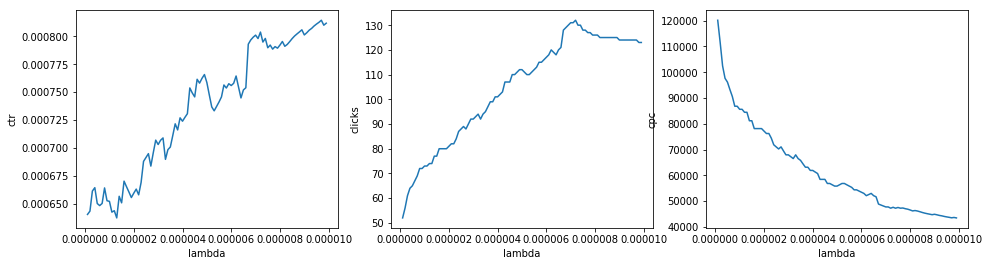

In [19]:
# Fix c=53, Tuning lambda_
res_dict_list = []
for lam_ in range(1, 100, 1):
    lam = lam_ * 0.0000001
    tdf = ortb2_bidding(val_df.copy(), c=45, lambda_=lam)
    res = estimate(tdf)
    res["lambda"] = lam
    res_dict_list.append(res)
    sys.stdout.write("\r{}/{} done".format(lam_ ,100))
    sys.stdout.flush()
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
x = [item["lambda"] for item in res_dict_list]
y = [item["ctr"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("ctr")
plt.plot(x, y)
ax1 = fig.add_subplot(132)
x = [item["lambda"] for item in res_dict_list]
y = [item["clicks"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("clicks")
plt.plot(x, y)
ax1 = fig.add_subplot(133)
x = [item["lambda"] for item in res_dict_list]
y = [item["cpc"] for item in res_dict_list]
plt.xlabel("lambda")
plt.ylabel("cpc")
plt.plot(x, y)

In [22]:
idx = np.argmax([item["clicks"] for item in res_dict_list])
res_dict_list[idx]

{'clicks': 132.0,
 'cpc': 47224.13636363636,
 'cpm': 37958.981603833905,
 'ctr': 0.00080380467546386223,
 'impressions': 164219.0,
 'lambda': 7.2e-06,
 'spend': 6233586.0}

* best ORTB2 parameter: c=45, lambda=7.2e-06